<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/incrementalLearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_

### DATA LOADER

In [ ]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)
# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### NETWORK

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def addOutputNodes(self, num_new_outputs):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + num_new_outputs)

        #xavier initialization
        # xavier_uniform_(self.fc.weight)

        #kaiming initialization
        # kaiming_uniform_(self.fc.weight)
        self.fc.weight.data[:out_features] = weight
        


def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

In [4]:
net = resnet32()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### LOSS & PARAMETERS

In [5]:
lr = 0.01
decay = 0.0001
epochs = 10
momentum = 0.9
factor = 5

In [6]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### TRAINING

In [7]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  distillation_loss = 0
  if (iteration != 0):
    # add 10 output nodes to the network
    network.addOutputNodes(num_classes)
    network.to(device)

  old_net = copy.deepcopy(network)
  
  #train the network
  for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs = data[0].to(device)
      labels = data[1].to(device)
      
      # Sets the gradients of all optimized torch.Tensor to zero.
      optimizer.zero_grad() 

      # forward: assign weights to each edge in each layer
      outputs = network.forward(inputs) 

       # calculate the classification loss 
      classification_loss = criterion(outputs,labels) 

      if (iteration > 0):
      # calculate the distillation loss
        distillation_loss = dist_loss(outputs, old_net, inputs) 
      
      loss = classification_loss + distillation_loss

      # redesign the weights evaluating the performance of the network
      loss.backward() 

      # update parameters
      optimizer.step()  

      running_loss += loss.item()

      # print every 20 mini-batches the average value of the loss accumulated in each batch
      if i % 20 == 19:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

In [8]:
 def dist_loss(outputs, old_net, inputs):
    out_old = torch.sigmoid(old_net.forward(inputs))
    out_old_new = torch.argmax(out_old, dim=1)
    distillation_loss = criterion(outputs, out_old_new)
    return distillation_loss

### TEST

In [ ]:
def test(testloader, iteration, network, acc):

  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
        
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

### EXECUTION 

[1,    20] loss: 2.245
[1,    40] loss: 2.029
[2,    20] loss: 1.955
[2,    40] loss: 1.874
[3,    20] loss: 1.736
[3,    40] loss: 1.690
[4,    20] loss: 1.633
[4,    40] loss: 1.504
[5,    20] loss: 1.443
[5,    40] loss: 1.447
[6,    20] loss: 1.430
[6,    40] loss: 1.336
[7,    20] loss: 1.275
[7,    40] loss: 1.217
[8,    20] loss: 1.125
[8,    40] loss: 1.093
[9,    20] loss: 1.011
[9,    40] loss: 0.995
[10,    20] loss: 1.052
[10,    40] loss: 0.986
[11,    20] loss: 1.032
[11,    40] loss: 0.880
[12,    20] loss: 0.852
[12,    40] loss: 0.817
[13,    20] loss: 0.794
[13,    40] loss: 0.848
[14,    20] loss: 0.854
[14,    40] loss: 0.777
[15,    20] loss: 0.659
[15,    40] loss: 0.619
[16,    20] loss: 0.571
[16,    40] loss: 0.529
[17,    20] loss: 0.598
[17,    40] loss: 0.521
[18,    20] loss: 0.407
[18,    40] loss: 0.385
[19,    20] loss: 0.403
[19,    40] loss: 0.404
[20,    20] loss: 0.585
[20,    40] loss: 0.573
[21,    20] loss: 0.509
[21,    40] loss: 0.398
[22,    20

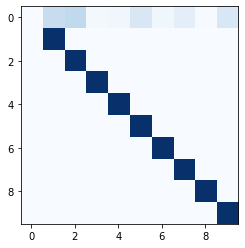

Accuracy of the network on the 0 iteration: 89 %
[1,    20] loss: 6.310
[1,    40] loss: 4.862
[2,    20] loss: 4.331
[2,    40] loss: 4.092
[3,    20] loss: 3.853
[3,    40] loss: 3.772
[4,    20] loss: 3.579
[4,    40] loss: 3.510
[5,    20] loss: 3.399
[5,    40] loss: 3.364
[6,    20] loss: 3.204
[6,    40] loss: 3.202
[7,    20] loss: 3.129
[7,    40] loss: 3.078
[8,    20] loss: 2.994
[8,    40] loss: 3.011
[9,    20] loss: 2.957
[9,    40] loss: 2.910
[10,    20] loss: 2.833
[10,    40] loss: 2.808
[11,    20] loss: 2.792
[11,    40] loss: 2.732
[12,    20] loss: 2.671
[12,    40] loss: 2.646
[13,    20] loss: 2.583
[13,    40] loss: 2.566
[14,    20] loss: 2.502
[14,    40] loss: 2.553
[15,    20] loss: 2.514
[15,    40] loss: 2.518
[16,    20] loss: 2.526
[16,    40] loss: 2.482
[17,    20] loss: 2.473
[17,    40] loss: 2.502
[18,    20] loss: 2.527
[18,    40] loss: 2.457
[19,    20] loss: 2.396
[19,    40] loss: 2.344
[20,    20] loss: 2.481
[20,    40] loss: 2.402
[21,    2

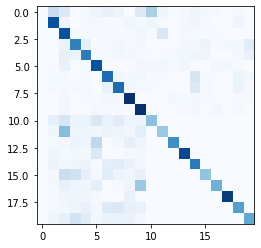

Accuracy of the network on the 1 iteration: 56 %
[1,    20] loss: 7.750
[1,    40] loss: 5.941
[2,    20] loss: 4.759
[2,    40] loss: 4.352
[3,    20] loss: 3.959
[3,    40] loss: 3.955
[4,    20] loss: 3.744
[4,    40] loss: 3.684
[5,    20] loss: 3.420
[5,    40] loss: 3.430
[6,    20] loss: 3.227
[6,    40] loss: 3.240
[7,    20] loss: 3.021
[7,    40] loss: 3.027
[8,    20] loss: 2.961
[8,    40] loss: 2.889
[9,    20] loss: 2.810
[9,    40] loss: 2.787
[10,    20] loss: 2.793
[10,    40] loss: 2.801
[11,    20] loss: 2.755
[11,    40] loss: 2.715
[12,    20] loss: 2.651
[12,    40] loss: 2.637
[13,    20] loss: 2.718
[13,    40] loss: 2.747
[14,    20] loss: 2.714
[14,    40] loss: 2.665
[15,    20] loss: 2.616
[15,    40] loss: 2.523
[16,    20] loss: 2.615
[16,    40] loss: 2.600
[17,    20] loss: 2.555
[17,    40] loss: 2.533
[18,    20] loss: 2.454
[18,    40] loss: 2.399
[19,    20] loss: 2.415
[19,    40] loss: 2.411
[20,    20] loss: 2.431
[20,    40] loss: 2.379
[21,    2

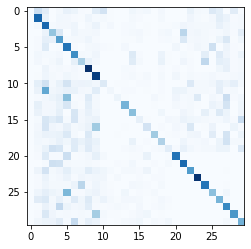

Accuracy of the network on the 2 iteration: 36 %
[1,    20] loss: 7.744
[1,    40] loss: 6.343
[2,    20] loss: 5.329
[2,    40] loss: 4.834
[3,    20] loss: 4.308
[3,    40] loss: 4.404
[4,    20] loss: 3.998
[4,    40] loss: 3.985
[5,    20] loss: 3.732
[5,    40] loss: 3.727
[6,    20] loss: 3.674
[6,    40] loss: 3.603
[7,    20] loss: 3.301
[7,    40] loss: 3.316
[8,    20] loss: 3.222
[8,    40] loss: 3.174
[9,    20] loss: 3.053
[9,    40] loss: 3.062
[10,    20] loss: 3.066
[10,    40] loss: 2.989
[11,    20] loss: 2.904
[11,    40] loss: 2.927
[12,    20] loss: 2.813
[12,    40] loss: 2.874
[13,    20] loss: 2.823
[13,    40] loss: 2.853
[14,    20] loss: 2.726
[14,    40] loss: 2.706
[15,    20] loss: 2.747
[15,    40] loss: 2.712
[16,    20] loss: 2.762
[16,    40] loss: 2.723
[17,    20] loss: 2.656
[17,    40] loss: 2.686
[18,    20] loss: 2.602
[18,    40] loss: 2.610
[19,    20] loss: 2.647
[19,    40] loss: 2.603
[20,    20] loss: 2.540
[20,    40] loss: 2.620
[21,    2

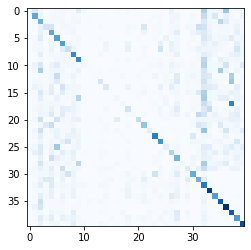

Accuracy of the network on the 3 iteration: 27 %
[1,    20] loss: 7.310
[1,    40] loss: 5.806
[2,    20] loss: 4.885
[2,    40] loss: 4.643
[3,    20] loss: 4.148
[3,    40] loss: 4.080
[4,    20] loss: 3.751
[4,    40] loss: 3.714
[5,    20] loss: 3.494
[5,    40] loss: 3.490
[6,    20] loss: 3.267
[6,    40] loss: 3.231
[7,    20] loss: 3.129
[7,    40] loss: 3.073
[8,    20] loss: 3.078
[8,    40] loss: 3.048
[9,    20] loss: 3.064
[9,    40] loss: 3.048
[10,    20] loss: 2.829
[10,    40] loss: 2.842
[11,    20] loss: 2.897
[11,    40] loss: 2.724
[12,    20] loss: 2.656
[12,    40] loss: 2.658
[13,    20] loss: 2.630
[13,    40] loss: 2.651
[14,    20] loss: 2.628
[14,    40] loss: 2.739
[15,    20] loss: 2.683
[15,    40] loss: 2.701
[16,    20] loss: 2.665
[16,    40] loss: 2.663
[17,    20] loss: 2.636
[17,    40] loss: 2.596
[18,    20] loss: 2.525
[18,    40] loss: 2.555
[19,    20] loss: 2.629
[19,    40] loss: 2.646
[20,    20] loss: 2.523
[20,    40] loss: 2.502
[21,    2

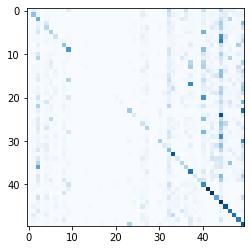

Accuracy of the network on the 4 iteration: 19 %
[1,    20] loss: 9.188
[1,    40] loss: 6.909
[2,    20] loss: 5.620
[2,    40] loss: 5.202
[3,    20] loss: 4.647
[3,    40] loss: 4.564
[4,    20] loss: 4.134
[4,    40] loss: 4.076
[5,    20] loss: 3.785
[5,    40] loss: 3.778
[6,    20] loss: 3.512
[6,    40] loss: 3.591
[7,    20] loss: 3.539
[7,    40] loss: 3.543
[8,    20] loss: 3.311
[8,    40] loss: 3.395
[9,    20] loss: 3.225
[9,    40] loss: 3.387
[10,    20] loss: 3.205
[10,    40] loss: 3.240
[11,    20] loss: 3.153
[11,    40] loss: 3.201
[12,    20] loss: 3.137
[12,    40] loss: 3.089
[13,    20] loss: 2.944
[13,    40] loss: 2.905
[14,    20] loss: 2.801
[14,    40] loss: 2.839
[15,    20] loss: 2.802
[15,    40] loss: 2.853
[16,    20] loss: 2.745
[16,    40] loss: 2.965
[17,    20] loss: 2.923
[17,    40] loss: 2.856
[18,    20] loss: 2.747
[18,    40] loss: 2.808
[19,    20] loss: 2.743
[19,    40] loss: 2.724
[20,    20] loss: 2.644
[20,    40] loss: 2.700
[21,    2

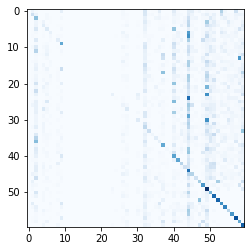

Accuracy of the network on the 5 iteration: 16 %
[1,    20] loss: 8.678
[1,    40] loss: 6.681
[2,    20] loss: 5.549
[2,    40] loss: 5.501
[3,    20] loss: 4.862
[3,    40] loss: 4.673
[4,    20] loss: 4.369
[4,    40] loss: 4.323
[5,    20] loss: 3.969
[5,    40] loss: 3.931
[6,    20] loss: 3.715
[6,    40] loss: 3.718
[7,    20] loss: 3.484
[7,    40] loss: 3.628
[8,    20] loss: 3.440
[8,    40] loss: 3.510
[9,    20] loss: 3.316
[9,    40] loss: 3.311
[10,    20] loss: 3.161
[10,    40] loss: 3.097
[11,    20] loss: 3.032
[11,    40] loss: 3.116
[12,    20] loss: 3.087
[12,    40] loss: 3.116
[13,    20] loss: 2.998
[13,    40] loss: 3.055
[14,    20] loss: 2.896
[14,    40] loss: 2.956
[15,    20] loss: 2.946
[15,    40] loss: 2.911
[16,    20] loss: 2.823
[16,    40] loss: 2.845
[17,    20] loss: 2.883
[17,    40] loss: 3.032
[18,    20] loss: 2.962
[18,    40] loss: 2.938
[19,    20] loss: 2.752
[19,    40] loss: 2.698
[20,    20] loss: 2.709
[20,    40] loss: 2.931
[21,    2

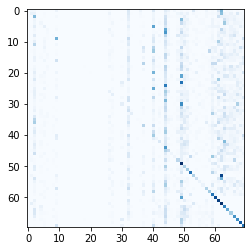

Accuracy of the network on the 6 iteration: 14 %
[1,    20] loss: 7.763
[1,    40] loss: 5.984
[2,    20] loss: 5.255
[2,    40] loss: 4.779
[3,    20] loss: 4.384
[3,    40] loss: 4.527
[4,    20] loss: 3.962
[4,    40] loss: 3.926
[5,    20] loss: 3.656
[5,    40] loss: 3.665
[6,    20] loss: 3.381


In [ ]:
# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations= 10 
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = [] 
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time

  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration

### CONFUSION MATRIX

Accuracy of the network on the 10000 test images: 9 %


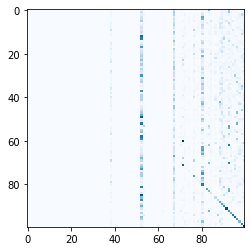

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

### RANDOM CLASSES


DATA LOADER


In [2]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


EXECUTION

In [10]:
import random
indices = list(range(0,100))
random.shuffle(indices)
dict_classes = dict(zip(indices,range(100)))
for i in range(len(trainset)):
  trainset[i][1] = dict_classes[trainset[i][1]]

Train the network, iteration:  0  on classes:  range(0, 10)
[1,    20] loss: 0.233
[1,    40] loss: 0.218
[1,    60] loss: 0.209
[1,    80] loss: 0.200
[1,   100] loss: 0.193
[1,   120] loss: 0.189
[1,   140] loss: 0.187
[2,    20] loss: 0.178
[2,    40] loss: 0.181
[2,    60] loss: 0.176
[2,    80] loss: 0.171
[2,   100] loss: 0.165
[2,   120] loss: 0.166
[2,   140] loss: 0.169
[3,    20] loss: 0.166
[3,    40] loss: 0.164
[3,    60] loss: 0.164
[3,    80] loss: 0.160
[3,   100] loss: 0.156
[3,   120] loss: 0.158
[3,   140] loss: 0.156
[4,    20] loss: 0.156
[4,    40] loss: 0.149
[4,    60] loss: 0.155
[4,    80] loss: 0.162
[4,   100] loss: 0.152
[4,   120] loss: 0.154
[4,   140] loss: 0.152
[5,    20] loss: 0.148
[5,    40] loss: 0.153
[5,    60] loss: 0.150
[5,    80] loss: 0.151
[5,   100] loss: 0.142
[5,   120] loss: 0.140
[5,   140] loss: 0.144
[6,    20] loss: 0.136
[6,    40] loss: 0.141
[6,    60] loss: 0.133
[6,    80] loss: 0.140
[6,   100] loss: 0.135
[6,   120] loss: 0.1

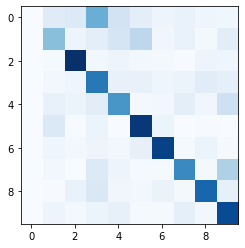

Accuracy of the network on the 0 iteration: 56 %
Train the network, iteration:  1  on classes:  range(10, 20)
[1,    20] loss: 1.641
[1,    40] loss: 1.874
[1,    60] loss: 1.791
[1,    80] loss: 1.696
[1,   100] loss: 1.604
[1,   120] loss: 1.526
[1,   140] loss: 1.484
[2,    20] loss: 1.573
[2,    40] loss: 1.514
[2,    60] loss: 1.424
[2,    80] loss: 1.393
[2,   100] loss: 1.386
[2,   120] loss: 1.471
[2,   140] loss: 1.444
[3,    20] loss: 1.360
[3,    40] loss: 1.348
[3,    60] loss: 1.352
[3,    80] loss: 1.366
[3,   100] loss: 1.351
[3,   120] loss: 1.365
[3,   140] loss: 1.336
[4,    20] loss: 1.320
[4,    40] loss: 1.388
[4,    60] loss: 1.261
[4,    80] loss: 1.321
[4,   100] loss: 1.293
[4,   120] loss: 1.327
[4,   140] loss: 1.286
[5,    20] loss: 1.226
[5,    40] loss: 1.309
[5,    60] loss: 1.259
[5,    80] loss: 1.282
[5,   100] loss: 1.306
[5,   120] loss: 1.259
[5,   140] loss: 1.191
[6,    20] loss: 1.182
[6,    40] loss: 1.284
[6,    60] loss: 1.272
[6,    80] loss:

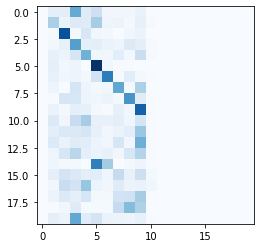

Accuracy of the network on the 1 iteration: 24 %
Train the network, iteration:  2  on classes:  range(20, 30)
[1,    20] loss: 1.174
[1,    40] loss: 1.186
[1,    60] loss: 1.171
[1,    80] loss: 1.126
[1,   100] loss: 1.119
[1,   120] loss: 1.158
[1,   140] loss: 1.120
[2,    20] loss: 1.063
[2,    40] loss: 1.115
[2,    60] loss: 1.092
[2,    80] loss: 1.097
[2,   100] loss: 1.092
[2,   120] loss: 1.038
[2,   140] loss: 1.088
[3,    20] loss: 1.050
[3,    40] loss: 1.046
[3,    60] loss: 0.989
[3,    80] loss: 1.037
[3,   100] loss: 1.014
[3,   120] loss: 1.021
[3,   140] loss: 1.028
[4,    20] loss: 0.965
[4,    40] loss: 0.998
[4,    60] loss: 1.002
[4,    80] loss: 1.016
[4,   100] loss: 0.983
[4,   120] loss: 0.994
[4,   140] loss: 1.010
[5,    20] loss: 0.969
[5,    40] loss: 0.967
[5,    60] loss: 1.005
[5,    80] loss: 0.971
[5,   100] loss: 0.980
[5,   120] loss: 0.999
[5,   140] loss: 0.990
[6,    20] loss: 0.972
[6,    40] loss: 0.982
[6,    60] loss: 0.989
[6,    80] loss:

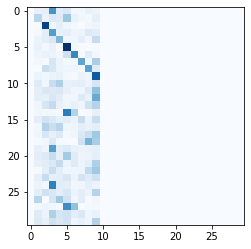

Accuracy of the network on the 2 iteration: 16 %
Train the network, iteration:  3  on classes:  range(30, 40)
[1,    20] loss: 1.043
[1,    40] loss: 1.053
[1,    60] loss: 1.050
[1,    80] loss: 1.068
[1,   100] loss: 1.045
[1,   120] loss: 1.052
[1,   140] loss: 1.072
[2,    20] loss: 1.010
[2,    40] loss: 0.990
[2,    60] loss: 1.010
[2,    80] loss: 1.048
[2,   100] loss: 0.955
[2,   120] loss: 0.987


KeyboardInterrupt: ignored

In [11]:
#TRYING TO RANDOMIZE CLASSES


# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
#import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  #classes_current_iter = dict(zip(indices[i*num_classes : i*num_classes+num_classes],range(i*num_classes,i*num_classes+num_classes)))
  # print(classes_current_iter)
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    #if(trainset[j][-1] in classes_current_iter.keys()):
      #trainset[j][-1] = classes_current_iter[trainset[j][-1]]
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])

  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time
  #print("Train_loader length: ",len(train_loader))
  #print("valid_loader length: ",len(valid_loader))
  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration

### try to plot confusionmatrix at each step

In [9]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network, acc):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
  plt.show()
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))